# BF Covariances

This shows the difference between the parallel (0,1) turnoff and the serial (1,0) turnoff.
The code to generate the eotest file can be found here: https://github.com/lsst-camera-dh/eotest/blob/594625ba31db62a75ed802da8d90ba2dc19a71e8/python/lsst/eotest/sensor/BFTask.py

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+995cec829e 	w_2023_29 setup


In [2]:
slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}### Single Amplifier:

In [3]:
slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

cov_samples = {"R24_S11": 35515.38594079467,
               "R02_S00": 40202.3028,
               "R03_S12": 45652.31107039715,
               "R21_S02": 35561.6843} # adu

def get_prekernel_matrix(inputPtc, amp, cov_sample): 
    mask = np.zeros(inputPtc.rawMeans[amp].shape, dtype=bool) # added
    index = np.argmin( ( np.asarray(inputPtc.rawMeans[amp]) - cov_sample )**2 )
    mask[index] = True # added
            
    _n = inputPtc.noiseMatrix[amp] 
    _g  = inputPtc.gain[amp] 
    _mu = np.asarray(inputPtc.rawMeans[amp])[mask]
    _C_model = np.asarray(inputPtc.covariancesModel[amp])[mask]

    A = (_C_model[0] / _mu**2) - (_n/_g**2)/(_mu**2)
    A[0][0] = (_C_model[0][0][0] / _mu**2) - (_mu/_g + _n[0][0]/_g**2)/(_mu**2)
    
    
    
    return A

slacAmps2 = {y: x for x, y in slacAmps.items()}
from lsst.daf.butler import Butler
butler = Butler("/repo/main")

# Single Amplifier

## R03-S12
__________

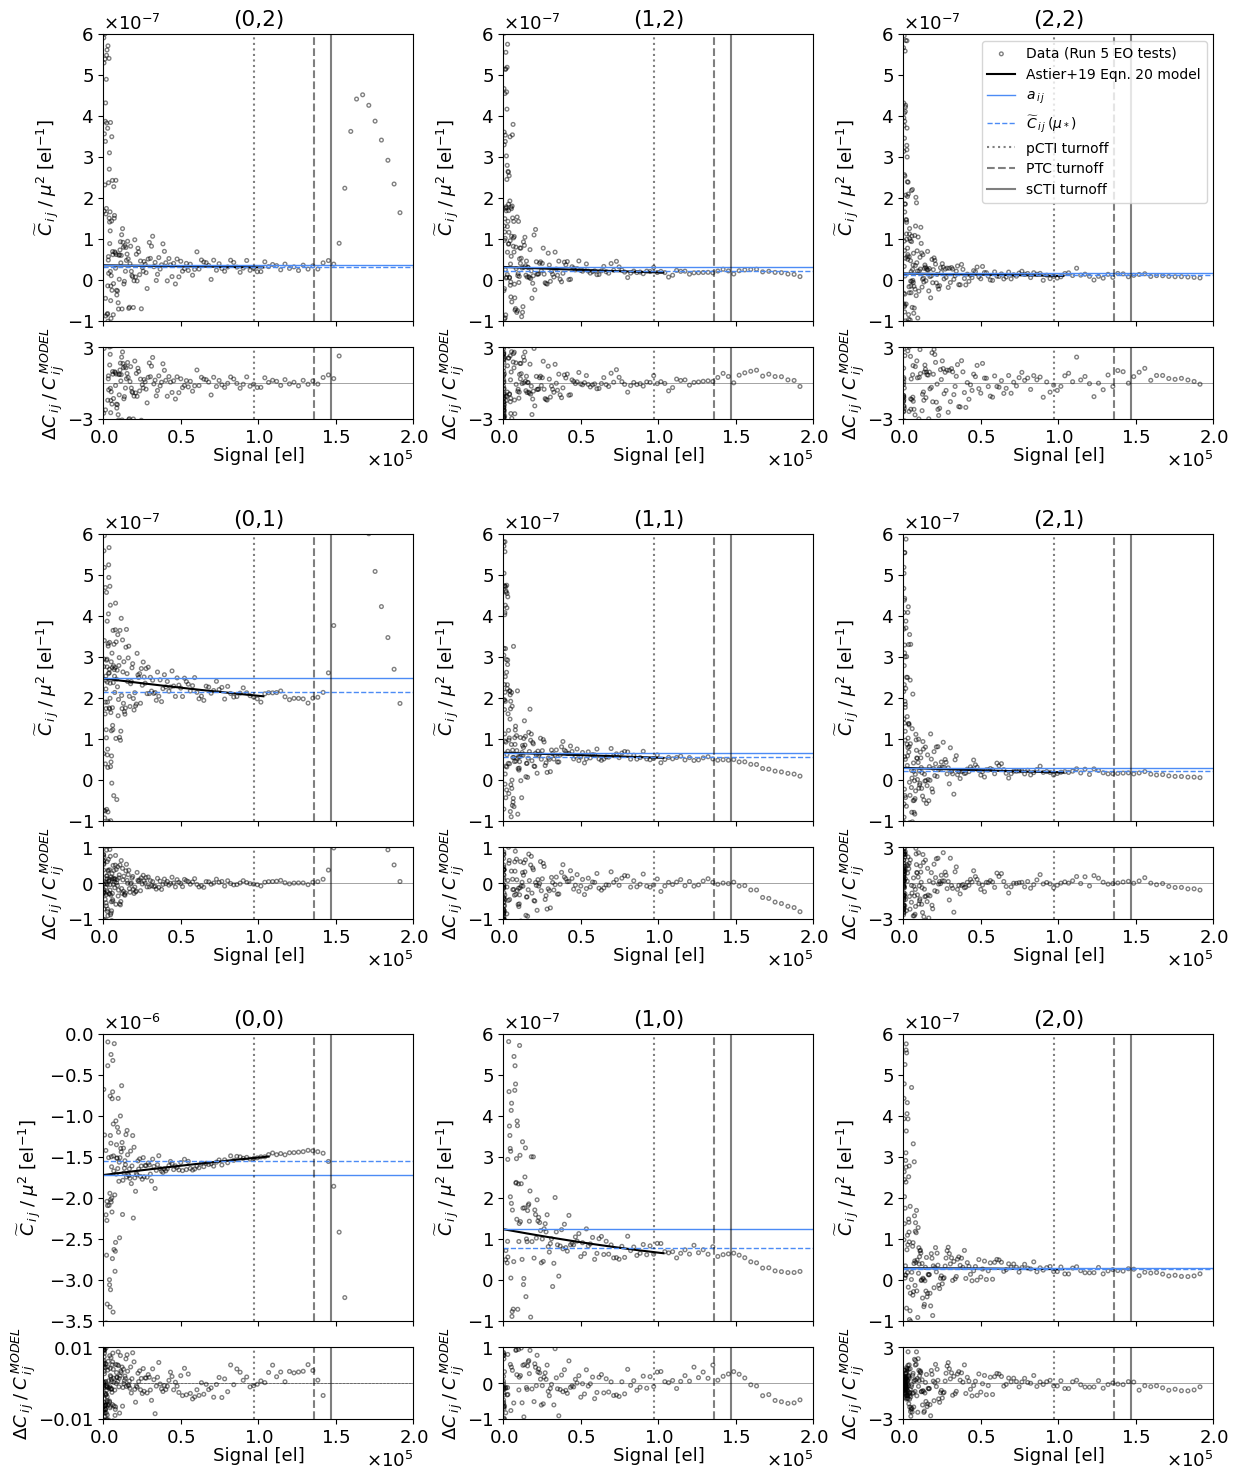

In [4]:
import matplotlib.gridspec as gridspec

from lsst.daf.butler import Butler

from lsst.obs.lsst import LsstCam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

# 45652.31107039715
# 35515.38594079467

sensor="R03_S12"
det = 23
fa = 0.791
amp = 'C00'
butler = Butler("/repo/main") 
ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections='u/abrought/BF/2023.09.15/ptc.R03-S12.trunc_to_newpcti')

import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *
ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, gains = getSensorData(sensor=sensor, detector=det)

camera = LsstCam().getCamera()
detector = camera.get(sensor)

def avg_dict(d, exclude_channels=[]):

        t = np.zeros((8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

def avg_dict2(d, exclude_channels=[]):

        t = np.zeros((338,8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

gains = []
for l, channel in enumerate(camera[0].getAmplifiers()):
    #print(l,channel.getName())
    gains.append(ptc.gain[channel.getName()])

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], hspace=0.3*.5)
sub_fig = fig.subfigures(3, 3)
for i in range(3):
    for j in range(3): # 00->20 01->10
        ax1 = sub_fig[2-j][i].add_subplot(gs[0])
        ax2 = sub_fig[2-j][i].add_subplot(gs[1])
        l = 0
        mask = np.asarray(ptc.expIdMask[amp])
        n  = ptc.noiseMatrix[amp]
        g  = ptc.gain[amp] 
        mu = np.asarray(ptc.rawMeans[amp])
        C  = np.asarray(ptc.covariances[amp])[:,i,j]
        C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
        if i==0 and j==0 and l==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.plot(mu[mask]*g, (C_model[mask] / mu[mask]**2) - (mu[mask]/g + n[0][0]/g**2)/(mu[mask]**2), "-", color='k')
            #residual = ((C[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2) - ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2))) / ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2)) 
            #ax2.scatter(mu[mask]*g, residual, s=2, color='#4c8bf5', alpha=0.25)
            ax2.set_ylim(-0.2,0.2)
            ax2.set_xlim(0,2.0e5)
            #ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax1.set_ylim(-3.5e-6,0.0e-6)
            #ax1.set_title(r"$a_{00} = \frac{1}{\mu^2}\left [ C_{00} - \left ( \frac{\mu}{g} + \frac{n_{00}}{g^2}\right ) \right ]$")
            ax1.set_title(f'({i},{j})'.format(i,j))
        elif i==0 and j==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7, edgecolor="k", facecolor="None", alpha=0.5)
        elif i==2 and j==2 and l==0:
            ax1.scatter(mu*g,  C / mu**2 - (n[i][j]/g**2)/mu**2 , s=7,edgecolor="k", facecolor="None", alpha=0.5, label="Data (Run 5 EO tests)")
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        else:

            ax1.scatter(mu*g,  C / mu**2  - (n[i][j]/g**2)/mu**2, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        
        #

        if i==0 and j==0:

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            res1 = ((C / mu**2) - (mu/g + n[0][0]/g**2))
            res2 = ((C_model / mu**2) - (mu/g + n[0][0]/g**2))
            residual = (C - C_model) / C_model
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)

            ax2.set_xlim(0,2.0e5)
            ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax2.set_xlabel("Signal [el]")
        else:
            ax1.plot(mu[mask] * np.mean(gains),C_model[mask] / mu[mask]**2 - (n[i][j]/g**2)/mu[mask]**2 , "-", color='k', label="Astier+19 Eqn. 20 model")

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            residual = ((C / mu**2) - (C_model / mu**2)) / (C_model / mu**2)
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax2.set_ylim(-1,1)
            ax2.set_xlim(0,2.0e5)
                
        if 2-j==0 or i==2:
            ax2.set_ylim(-3.0,3.0)
            ax2.set_yticks([-3.0,3.0])
            pass
        
        
        ax1.axhline(ptc.aMatrix[amp][i][j], color="#4c8bf5", linewidth=1, linestyle="-", label=r"$a_{\,i\,j}$")
        A = get_prekernel_matrix(ptc, amp, cov_samples[sensor])
        ax1.axhline(A[i][j], color="#4c8bf5", linewidth=1,linestyle="--", label=r'$\widetilde{C}_{\,i\,j}\,(\mu_*)$')
        ax1.set_xlim(0,2.0e5)
        ax2.set_xlabel("Signal [el]", labelpad=-0.25)
        ax2.set_ylabel(r"$\Delta C_{\,i\,j}\:/\:C_{\,i\,j}^{\,MODEL}$", labelpad=0)
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #ax1.xaxis.major.formatter._useMathText = True
        ax1.yaxis.major.formatter._useMathText = True
        
        ax1.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", label="pCTI turnoff", alpha=0.5)
        ax2.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", alpha=0.5)
        ax1.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", label="PTC turnoff", alpha=0.5)
        ax2.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", alpha=0.5)
        ax1.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", label="sCTI turnoff", alpha=0.5)
        ax2.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", alpha=0.5)
        
        ax2.axhline(0.0, linestyle="-", linewidth=0.5, color="k", alpha=0.5)
        
        if i==0 and j==0:
            ax2.axhline(0.0, linestyle="--", linewidth=0.5, color="k", alpha=0.5)
            ax2.set_ylim(-0.010,0.010)
            ax2.set_yticks([-0.01,0.01])
        #elif 2-j==1 and i==0:
        #    ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        if i==2 and j==2:
            ax1.legend(frameon=True, ncol=1,fontsize=10, loc=1)
        plt.setp( ax1.get_xticklabels(), visible=False)
        ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
        #ax1.set_title(f"$a_{{\:{i}\:{j}}}$")
        #ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
        ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        

#axs[0][1].set_title(r'$a_{01}$')
#axs[0][2].set_title(r'$a_{02}$')
#axs[1][0].set_title(r'$a_{10}$')
#axs[2][0].set_title(r'$a_{20}$')
#axs[1][1].set_title(r'$a_{11}$')
#axs[2][2].set_title(r'$a_{22}$')
#axs[2][1].set_title(r'$a_{21}$')
#axs[1][2].set_title(r'$a_{12}$')
#axs[2][0].set_xlabel("Signal [el]")
#axs[2][1].set_xlabel("Signal [el]")
#axs[2][2].set_xlabel("Signal [el]")


plt.savefig("../plots/analytical_a_matrix_itl.png", bbox_inches="tight")

## R24-S11
__________

241
241
241
241
241
241
241
241
241


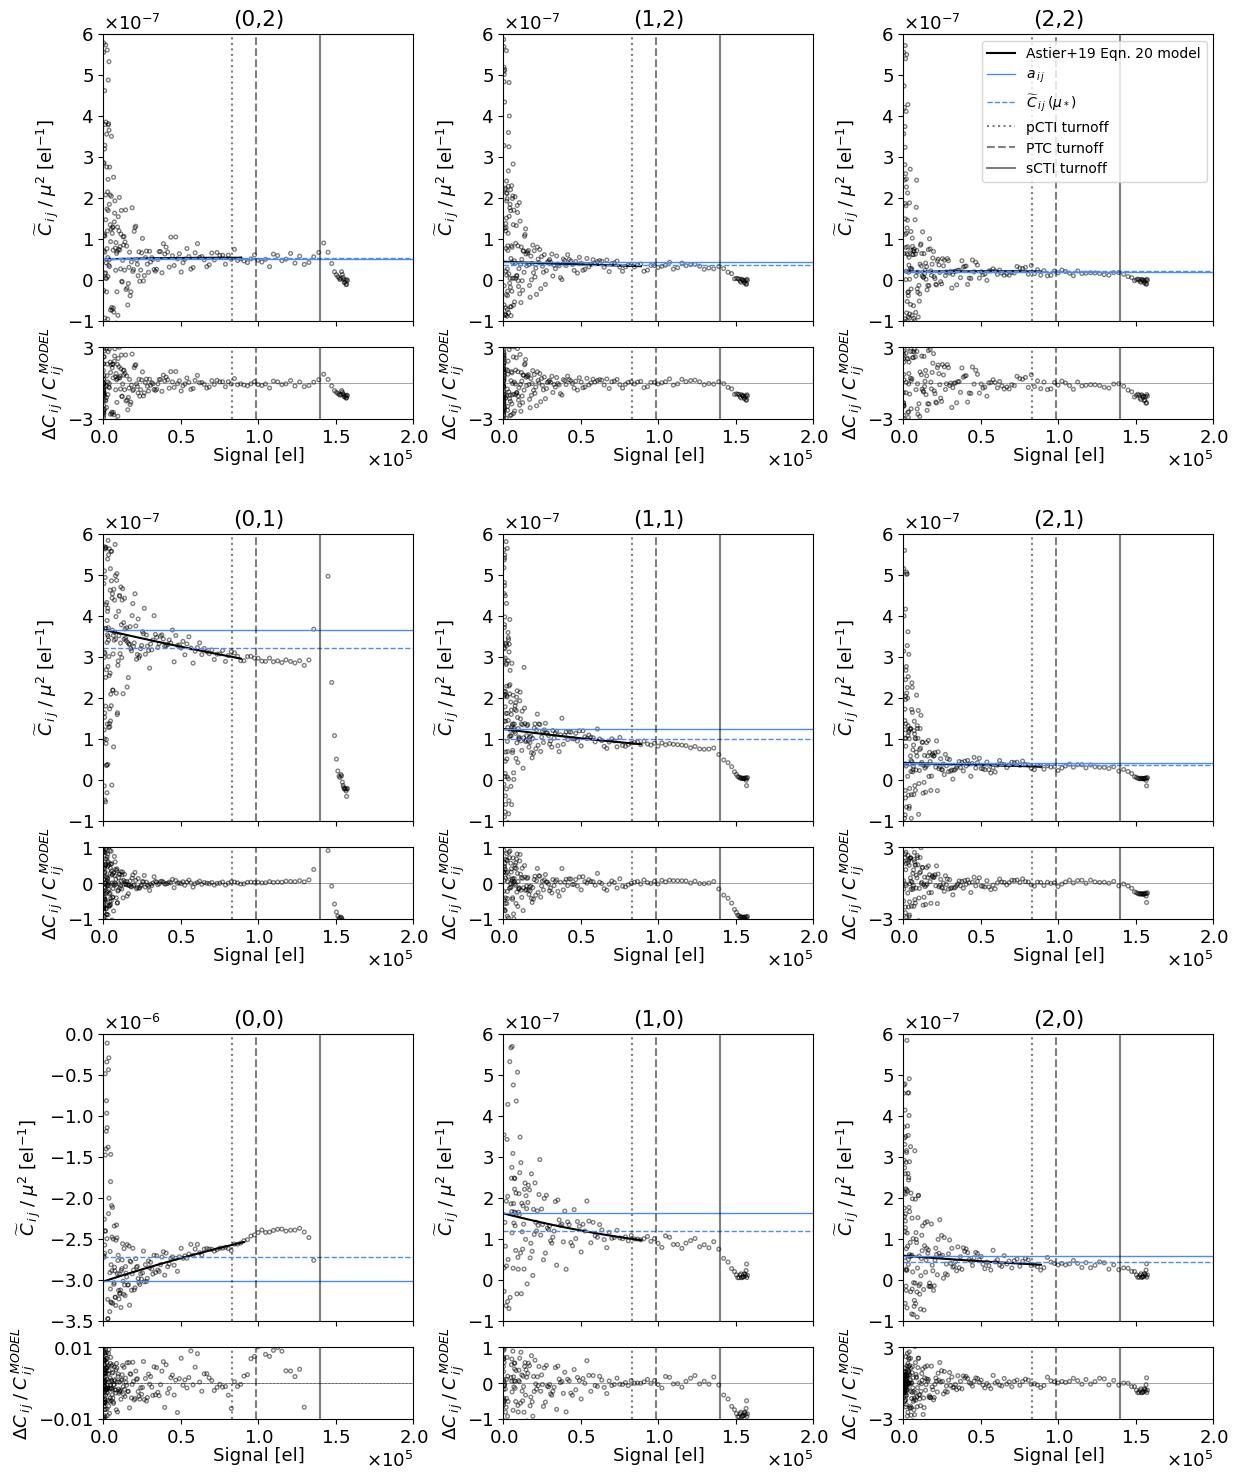

In [5]:
import matplotlib.gridspec as gridspec

from lsst.daf.butler import Butler

from lsst.obs.lsst import LsstCam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

sensor="R24_S11"
det = 112
fa = 0.791
amp = 'C00'
butler = Butler("/repo/main") 
ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections='u/abrought/BF/2023.09.15/ptc.R24-S11.trunc_to_newpcti')

import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *
ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, gains = getSensorData(sensor=sensor, detector=det)

camera = LsstCam().getCamera()
detector = camera.get(sensor)

def avg_dict(d, exclude_channels=[]):

        t = np.zeros((8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

def avg_dict2(d, exclude_channels=[]):

        t = np.zeros((338,8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

gains = []
for l, channel in enumerate(camera[0].getAmplifiers()):
    #print(l,channel.getName())
    gains.append(ptc.gain[channel.getName()])

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], hspace=0.3*.5)
sub_fig = fig.subfigures(3, 3)
for i in range(3):
    for j in range(3): # 00->20 01->10
        ax1 = sub_fig[2-j][i].add_subplot(gs[0])
        ax2 = sub_fig[2-j][i].add_subplot(gs[1])
        l = 1
        mask = np.asarray(ptc.expIdMask[amp])
        print(mask.sum())
        n  = ptc.noiseMatrix[amp]
        g  = ptc.gain[amp] 
        mu = np.asarray(ptc.rawMeans[amp])
        C  = np.asarray(ptc.covariances[amp])[:,i,j]
        C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
        if i==0 and j==0 and l==1:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.plot(mu[mask]*g, (C_model[mask] / mu[mask]**2) - (mu[mask]/g + n[0][0]/g**2)/(mu[mask]**2), "-", color='k')
            #residual = ((C[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2) - ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2))) / ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2)) 
            #ax2.scatter(mu[mask]*g, residual, s=2, color='#4c8bf5', alpha=0.25)
            ax2.set_ylim(-0.2,0.2)
            ax2.set_xlim(0,2.0e5)
            #ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax1.set_ylim(-3.5e-6,0.e-6)
            #ax1.set_title(r"$a_{00} = \frac{1}{\mu^2}\left [ C_{00} - \left ( \frac{\mu}{g} + \frac{n_{00}}{g^2}\right ) \right ]$")
            ax1.set_title(f'({i},{j})'.format(i,j))
        elif i==0 and j==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7, edgecolor="k", facecolor="None", alpha=0.5)
        elif i==2 and j==2 and l==0:
            ax1.scatter(mu*g,  C / mu**2 - (n[i][j]/g**2)/mu**2 , s=7,edgecolor="k", facecolor="None", alpha=0.5, label="Data (Run 5 EO tests)")
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        else:

            ax1.scatter(mu*g,  C / mu**2  - (n[i][j]/g**2)/mu**2, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        
        #

        if i==0 and j==0:

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            res1 = ((C / mu**2) - (mu/g + n[0][0]/g**2))
            res2 = ((C_model / mu**2) - (mu/g + n[0][0]/g**2))
            residual = (C - C_model) / C_model
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)

            ax2.set_xlim(0,2.0e5)
            ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax2.set_xlabel("Signal [el]")
        else:
            ax1.plot(mu[mask] * np.mean(gains),C_model[mask] / mu[mask]**2 - (n[i][j]/g**2)/mu[mask]**2 , "-", color='k', label="Astier+19 Eqn. 20 model")

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            residual = ((C / mu**2) - (C_model / mu**2)) / (C_model / mu**2)
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax2.set_ylim(-1,1)
            ax2.set_xlim(0,2.0e5)
                
        if 2-j==0 or i==2:
            ax2.set_ylim(-3.0,3.0)
            ax2.set_yticks([-3.0,3.0])
            pass
        
        
        ax1.axhline(ptc.aMatrix[amp][i][j], color="#4c8bf5", linewidth=1, linestyle="-", label=r"$a_{\,i\,j}$")
        A = get_prekernel_matrix(ptc, amp, cov_samples[sensor])
        ax1.axhline(A[i][j], color="#4c8bf5", linewidth=1,linestyle="--", label=r'$\widetilde{C}_{\,i\,j}\,(\mu_*)$')
        ax1.set_xlim(0,2.0e5)
        ax2.set_xlabel("Signal [el]", labelpad=-0.25)
        ax2.set_ylabel(r"$\Delta C_{\,i\,j}\:/\:C_{\,i\,j}^{\,MODEL}$", labelpad=0)
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #ax1.xaxis.major.formatter._useMathText = True
        ax1.yaxis.major.formatter._useMathText = True
        
        ax1.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", label="pCTI turnoff", alpha=0.5)
        ax2.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", alpha=0.5)
        ax1.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", label="PTC turnoff", alpha=0.5)
        ax2.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", alpha=0.5)
        ax1.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", label="sCTI turnoff", alpha=0.5)
        ax2.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", alpha=0.5)
        
        ax2.axhline(0.0, linestyle="-", linewidth=0.5, color="k", alpha=0.5)
        
        if i==0 and j==0:
            ax2.axhline(0.0, linestyle="--", linewidth=0.5, color="k", alpha=0.5)
            ax2.set_ylim(-0.010,0.010)
            ax2.set_yticks([-0.01,0.01])
        #elif 2-j==1 and i==0:
        #    ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        if i==2 and j==2:
            ax1.legend(frameon=True, ncol=1,fontsize=10, loc=1)
        plt.setp( ax1.get_xticklabels(), visible=False)
        ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
        #ax1.set_title(f"$a_{{\:{i}\:{j}}}$")
        #ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
        ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        

#axs[0][1].set_title(r'$a_{01}$')
#axs[0][2].set_title(r'$a_{02}$')
#axs[1][0].set_title(r'$a_{10}$')
#axs[2][0].set_title(r'$a_{20}$')
#axs[1][1].set_title(r'$a_{11}$')
#axs[2][2].set_title(r'$a_{22}$')
#axs[2][1].set_title(r'$a_{21}$')
#axs[1][2].set_title(r'$a_{12}$')
#axs[2][0].set_xlabel("Signal [el]")
#axs[2][1].set_xlabel("Signal [el]")
#axs[2][2].set_xlabel("Signal [el]")


plt.savefig("../plots/analytical_a_matrix_e2v.png", bbox_inches="tight")